# initialization

import matplotlib plotting routines

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

default_size = 12 # change matplotlib default font size from 10 to 12
mpl.rc('xtick', labelsize = default_size)
mpl.rc('ytick', labelsize = default_size)

import numpy (numerical python) routines

In [3]:
# from numpy import *
from numpy import loadtxt, savetxt, array, ndarray, linspace, cos, pi, sqrt, diag, average, absolute

import scipy (scientific python) curve fitting and data analysis routines

In [4]:
from scipy.optimize import curve_fit  # nonlinear curve fitting 
from scipy.stats import chi2          # 'chi-square' goodness of fit calculation

# import data

In [5]:
filename = '650 nm calibration with error.csv'

angle, V_pd, V_pd_delta = loadtxt(filename, 
    delimiter = ',', 
    skiprows = 1, 
    unpack = True)

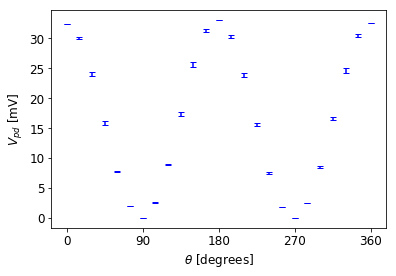

In [6]:
plt.figure() 

#label axes, chose font size 
plt.xlabel(r"$\theta$ [degrees]", fontsize = 12)
plt.ylabel(r"$V_{pd}$ [mV]", fontsize = 12)
plt.xticks([0, 90, 180, 270, 360])

#plot the data! 
plt.errorbar(
    angle, V_pd,  xerr=None, yerr=V_pd_delta, 
    linestyle = 'none', color = 'blue',  capsize = 3, capthick = 1)

plt.show()


# curve fitting to physical model

variation of light intensity with relative polarizer angle $\phi$

## define mathematical model

$ I(\theta) = I_0 \cos^2(\theta - {\theta}_0)+ \textrm{offset} = \frac{1}{2}I_0\left[1 + \cos(2 (\theta - \theta_0))\right]+ \textrm{offset}$ 

define Python function for calculation of $I(\theta)$

In [7]:
def polarization_model_1(phi, I_0, phi_0, offset): # variation of light intensity with relative polarizer angle phi
    return I_0 * (1 + cos(2 * (phi - phi_0)))/2 + offset

In [8]:
def polarization_model_2(phi, I_0, phi_0, offset):  # alternate mathematical formalism  
    return I_0 * (cos((phi - phi_0)))**2 + offset

make initial guess for fitting parameters

In [9]:
# initial guess for polarization models 
I0 = 33.0    #peak value - offset voltage, in mV
phi0 = 0.0   #offset angle, in radians
offset0 = 0.2 #offset voltage, in mV

initial_guess=array([I0, phi0, offset0])

convert data from degrees to radians for calculation of cosine

In [10]:
theta = angle * pi / 180  # convert to radians

## run curve fit 
execute non-linear curve fit, taking into account experimentally inferred uncertainty (sigma)

In [11]:
fit, covariance = curve_fit(polarization_model_1, theta, V_pd, 
                       p0 = initial_guess, 
                       sigma = V_pd_delta, absolute_sigma = True)

#bounds=([0, -np.inf, 0], [np.inf, np.inf, 5]
error = sqrt(diag(covariance))

I_0 = fit[0]
phi_0 = fit[1]
offset = fit[2]

print()
print('I_0    = ','{:.3f}'.format(fit[0]), '±', '{:.3f}'.format(error[0]), ' mV')
print('offset = ','{:.4f}'.format(fit[2]), '±', '{:.3f}'.format(error[2]), ' mV')
print('phi_0  = ','{:.4f}'.format(fit[1]), '±', '{:.4f}'.format(error[1]), 'radian')

print('       = ','{:.4f}'.format(fit[1]*180/pi), '±', '{:.4f}'.format(error[1]*180/pi), 'degrees')


I_0    =  32.621 ± 0.012  mV
offset =  0.0226 ± 0.009  mV
phi_0  =  -0.0182 ± 0.0009 radian
       =  -1.0410 ± 0.0495 degrees


## show results

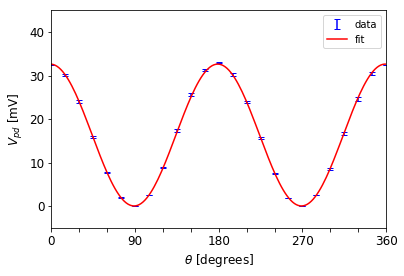

In [12]:
plt.figure() 

#label axes, chose font size 
plt.xlabel(r"$\theta$ [degrees]", fontsize = 12)
plt.ylabel(r"$V_{pd}$ [mV]", fontsize = 12)

#plot the data! 
plt.errorbar(
    angle, V_pd,  xerr=None, yerr=V_pd_delta, 
    linestyle = 'none', color = 'blue',  capsize = 3, capthick = 1, label = 'data')

#create curve showing fit to data 
angle_fit = linspace(0, 360, 180)
theta_fit = angle_fit * pi / 180
V_pd_fit = polarization_model_1(theta_fit, I_0, phi_0, offset)

#plot the curve fit 
plt.errorbar(angle_fit, V_pd_fit, xerr = None, yerr = None, color = 'red', label = 'fit' )
plt.xlim(0, 360)
plt.ylim(-5, 45)
plt.xticks([0,   30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], 
           ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')
plt.show()


# statistical analysis of fit

## residuals

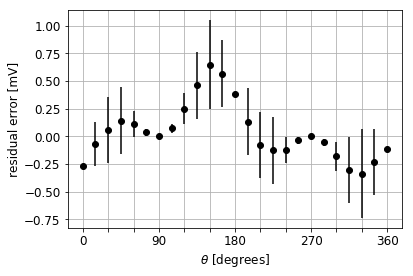

average residual error |model-data|  = 0.192 mV
average experimental uncertainty     = 0.176 mV


In [13]:
# residual analysis
V_pd_model = polarization_model_1(theta, I_0, phi_0, offset)
residual = V_pd - V_pd_model

plt.figure()
plt.xlabel(r"$\theta$ [degrees]", fontsize = 12)
plt.ylabel(r"residual error [mV]", fontsize = 12)
plt.errorbar(angle, residual, xerr=None, yerr= V_pd_delta, linestyle = 'none', color = 'black', marker = 'o')
plt.xticks([0,   30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], 
           ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.grid(1)
plt.show()

print('average residual error |model-data|  =', '{:.3f}'.format(average(absolute(residual))), 'mV')
print('average experimental uncertainty     =', '{:.3f}'.format(average(V_pd_delta)), 'mV')

## goodness of fit

In [14]:
chisq = sum((residual/ V_pd_delta))**2
degrees_of_freedom = len(residual) - 3
reduced_chisq = chisq / degrees_of_freedom
CDF = chi2.cdf(chisq, degrees_of_freedom)
print('chi-square         = ',chisq)
print('degrees of freedom = ',degrees_of_freedom)
print('reduced chi-square = ',reduced_chisq)
print()
print('fractional probability of chisq ≤', chisq, 'for ', degrees_of_freedom, 'dof is', CDF)

chi-square         =  7.708430854265782
degrees of freedom =  22
reduced chi-square =  0.3503832206484446

fractional probability of chisq ≤ 7.708430854265782 for  22 dof is 0.002148213541386696


Conclusion: fit looks good but it appears that overall, our experimental estimate of the uncertainty is too large. We will address this later when we consider propagation of uncertainty. 